In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, roc_auc_score, auc, accuracy_score, f1_score, confusion_matrix, mean_squared_error
from sklearn import tree 
import xgboost as xgb_package
import seaborn as sns

In [2]:
#reading files
all_pairs = pd.read_csv("all_pairs.csv", sep= ";")
all_pairs = all_pairs.dropna(how='all')              # drops fully empty rows
all_pairs = all_pairs.dropna(axis=1, how='all')      # drops fully empty columns

In [3]:
all_pairs = all_pairs[(all_pairs['neighbour DisProt IDP'] == 1)]
all_pairs.shape

(1160, 84)

In [4]:
npos = len(all_pairs[all_pairs['neighbour biomarker for target?'] == 1])
print(npos)

160


In [5]:
# Defining positive control
training_pos =all_pairs[all_pairs['neighbour biomarker for target?'] == 1]

In [6]:
# Negative control = not biomarker in CIViCmine + random sampling
training_neg = all_pairs[
    (all_pairs['neighbour biomarker for target?'] == 0) &
    (all_pairs['prognostic'] == 0) &
    (all_pairs['predisposing'] == 0) &
    (all_pairs['diagnostic'] == 0) &
    (all_pairs['predictive'] == 0)]
nneg = len(training_neg)
print(nneg)
training_neg_extra = all_pairs[all_pairs['neighbour biomarker for target?'] == 0].sample(n=(npos-nneg), random_state=42)
training_neg = pd.concat([training_neg_extra, training_neg], ignore_index=True)
training_neg.shape

18


(160, 84)

In [7]:
training = pd.concat([training_pos, training_neg], ignore_index=True)

In [8]:
#titles list
titles = list(training.head())
CSN = [s for s in titles if "CSN" in s]
SIGNOR = [s for s in titles if "SIGNOR" in s]
ReactomeFI = [s for s in titles if "ReactomeFI" in s]
print(CSN, SIGNOR, ReactomeFI)

['neighbour in CSN', 'target in CSN', 'both in CSN', 'in triangle - CSN', 'no. of triangles - CSN', 'no. of in cycle - CSN', 'no. of in unbalanced triangle - CSN', 'neighbour – target inhibition - CSN', 'target – neighbour stimulation - CSN', 'neighbour – target stimulation - CSN', 'target – neighbour inhibition - CSN', 'DisProt neighbour third partner - CSN', 'target third partner - CSN', 'neighbour bridgeness - CSN', 'neighbour betweenness - CSN', 'target bridgeness - CSN', 'target betweenness - CSN'] ['neighbour in SIGNOR', 'target in SIGNOR', 'both in SIGNOR', 'in  triangle - SIGNOR', 'no. of triangles - SIGNOR', 'no. of in  cycle - SIGNOR', 'no. of in  unbalanced triangle - SIGNOR', 'neighbour – target inhibition - SIGNOR', 'target – neighbour stimulation - SIGNOR', 'neighbour – target stimulation - SIGNOR', 'target – neighbour inhibition - SIGNOR', 'DisProt neighbour third partner - SIGNOR', 'target third partner - SIGNOR', 'neighbour bridgeness - SIGNOR', 'neighbour betweenness 

In [9]:
#what to drop
to_drop = ["neighbour UniProt", "neighbour name - universal", "target UniProt", "target name - universal", 
           "prognostic", "predisposing", "diagnostic", "predictive",
           "neighbour DisProt IDP", "neighbour in AlphaFold", "neighbour AlphaFold average pLLDT", 
           "neighbour AlphaFold disorder %", "neighbour in IUPred", "neighbour IUPred long score", 
           "neighbour IUPred long disorder %", "neighbour IUPred short score", 
           "neighbour IUPred short disorder %", "target AlphaFold average pLLDT",
           "target AlphaFold disorder %", "target IUPred long score", "target IUPred long disorder %", 
           "target IUPred short score", "target IUPred short disorder %"]
only_CSN = to_drop + SIGNOR + ReactomeFI
only_SIGNOR = to_drop + CSN + ReactomeFI 
only_ReactomeFI = to_drop + CSN + SIGNOR

In [10]:
#classifiers - hyperparameters optimalised
xgb = xgb_package.XGBClassifier(n_estimators=1000,
                                random_state=42,
                                subsample= 0.75,
                                scale_pos_weight= 0.25,
                                reg_lambda= 0,
                                reg_alpha= 0.5,
                                min_child_weight= 0.5,
                                max_leaves= 11,
                                max_depth= 7,
                                max_delta_step= 1,
                                max_bin= 32,
                                learning_rate= 1,
                                importance_type= 'cover',
                                grow_policy= 'lossguide',
                                gamma= 0.5,
                                criterion= 'log_loss',
                                booster= 'gbtree')
rfc = RandomForestClassifier(n_estimators=1000,
                             random_state= 42,
                             warm_start= False, #disabled, otherwise gives error with multiple training sets
                             oob_score= False,
                             n_jobs= 31,
                             min_weight_fraction_leaf= 0.1,
                             min_samples_split= 4,
                             min_samples_leaf= 5,
                             max_samples= 71,
                             max_leaf_nodes= 29,
                             max_features= 'sqrt',
                             max_depth= 3,
                             criterion= 'log_loss',
                             class_weight= 'balanced',
                             ccp_alpha= 0)

In [11]:
#data preparation
def prepare_data(drop_train, drop_test, training=training, test=training):
    """
    This function prepares the training and test data for the machine learning.
    Drops the previously selected columns using the drop_test list and renames the remaining columns.
    Splits the data to input parameters and labels.

    Args:
        drop_train: The list of column names which are going to be dropped from the training dataframe.
        drop_test: The list of column names which are going to be dropped from the test dataframe. 
        training: The dataframe of input parameters which are intended to use to the training of the machine learning model.
        test: The dataframe of input parameters which are intended to use to the testing of the machine learning model.

    Returns:
        X_train: The input data from the training dataframe.
        X_test: The input data from the test dataframe.
        y_train: The labels from the training dataframe.
        y_test: The labels from the test dataframe.

    """
    training_deleted = training.drop(columns= drop_train)
    training_deleted.columns = ['neighbour in network', 
                                'neighbour DisProt disorder content', 
                                'neighbour preclinical target',
                                'neighbour MCG target', 
                                'target in network', 
                                'target of small molecule',
                                'target of antibody', 
                                'target DisProt IDP',
                                'target DisProt disorder content',
                                'both in network', 
                                'both in all 3',
                                'in triangle - network', 
                                'not in any triangle', 
                                'no. of triangles - network',
                                'no. of in cycle - network', 
                                'no. of in unbalanced triangle - network',
                                'neighbour – target inhibition - network',
                                'target – neighbour stimulation - network',
                                'neighbour – target stimulation - network',
                                'target – neighbour inhibition - network',
                                'DisProt neighbour third partner - network', 
                                'target third partner - network',
                                'neighbour bridgeness - network', 
                                'neighbour betweenness - network',
                                'target bridgeness - network', 
                                'target betweenness - network',
                                'neighbour biomarker for target?']
    X_train = training_deleted.iloc[:,:-1]
    y_train = training_deleted.iloc[:, -1]
    test_deleted = test.drop(columns= drop_test)
    test_deleted.columns = ['neighbour in network', 
                                'neighbour DisProt disorder content', 
                                'neighbour preclinical target',
                                'neighbour MCG target', 
                                'target in network', 
                                'target of small molecule',
                                'target of antibody', 
                                'target DisProt IDP',
                                'target DisProt disorder content',
                                'both in network', 
                                'both in all 3',
                                'in triangle - network', 
                                'not in any triangle', 
                                'no. of triangles - network',
                                'no. of in cycle - network', 
                                'no. of in unbalanced triangle - network',
                                'neighbour – target inhibition - network',
                                'target – neighbour stimulation - network',
                                'neighbour – target stimulation - network',
                                'target – neighbour inhibition - network',
                                'DisProt neighbour third partner - network', 
                                'target third partner - network',
                                'neighbour bridgeness - network', 
                                'neighbour betweenness - network',
                                'target bridgeness - network', 
                                'target betweenness - network',
                                'neighbour biomarker for target?']
    X_test = test_deleted.iloc[:,:-1]
    y_test = test_deleted.iloc[:, -1]
    return X_train, X_test, y_train, y_test

In [12]:
#teaching - ROC/PR function, scores
def teach_print_test_all(X_train, X_test, y_train, y_test, classifier, what):
    """
    This function teaches and tests the selected machine learning models while also calculating different metrics.
    Fits StandardScaler on the training data and transforms the training and test data.
    Makes predictions on the training and test dataframes.
    Calculates and returns accuracy, F1 score and ROC AUC.
    Based on selection, draws the ROC or PR curve.

    Args:
        X_train: The input data which will be used for training the model.
        X_test: The input data which will be used for testing the model.
        y_train: The labels for the X_train dataframe.
        y_test: The labels for the X_test dataframe.
        classifier: The choosen classification algorhythm.
        what: The selected graph drawn based on the performance of the classificator. Options: "ROC" or "PR".

    Returns:
        classifier_pred_train: Predictions on the training dataset.
        classifier_pred_test: Predictions on the test dataset.
        display: The display of the choosen graph.
        params: The list of the calculated metrics, such as accuracy, FR score, ROC AUC.

    """
    #fitting scale
    scale = StandardScaler()
    scale.fit(X_train)
    X_train = scale.transform(X_train)
    X_test = scale.transform(X_test)
        
    #teaching
    classifier.fit(X_train, y_train)

    classifier_pred_train = classifier.predict(X_train)
    classifier_pred_test = classifier.predict(X_test)
    
    #accuracy+f1+auc
    acc = accuracy_score(y_test, classifier_pred_test)
    f1 = f1_score(y_test, classifier_pred_test)
    test_auc = roc_auc_score(y_test, classifier_pred_test)
    params= [acc, f1, test_auc]
    print(f"Accuracy: {acc}\n F1 score: {f1}\n Test AUC: {test_auc}")  
    print(params)    
    
    #test ROC curve
    if what == "ROC":
        ax1 = plt.gca()
        display = RocCurveDisplay.from_estimator(classifier, X_test, y_test, ax=ax1, alpha=0.8)
        #plt.show()
    
    #precision recall
    elif what == "PR":
        ax2 = plt.gca()
        display = PrecisionRecallDisplay.from_estimator(classifier, X_test, y_test, ax=ax2, alpha=0.8)
        #plt.show() 
        
    else: 
        print("Please give a valid option.")
    
    return classifier_pred_train, classifier_pred_test, display, params

In [13]:
def params_heatmap(params_xgb, params_rfc):
    """
    This function draws heatmap based on the performance metrics of the XGBoost and Random Forest algorhythms.
    Puts the input parameters into a dictionary, then into a dataframe.
    Transposes the dataframe to make the heatmap more easily understandable.
    Sets the name of the columns based on the name of the parameters: "Accuracy", "F1-score", "Test AUC score".
    Draws the heatmap.
    Returms the dataframe of the parameters.

    Args:
        params_xgb: Accuracy, F1-score, test AUC score for the XGBoost algorhythm.
        params_rfc: Accuracy, F1-score, test AUC score for the Random Forest algorhythm.

    Returns:
        params: Dataframe of the XGBoost and Random forest parameters.

    """
    params_dict = {'XGBoost': params_xgb, 'Random forest': params_rfc}
    print(dict)
    params = pd.DataFrame(params_dict)
    params = params.transpose()
    params = params.set_axis(["Accuracy", "F1-score", "Test AUC score"], axis=1)
    sns.heatmap(params, annot=True)
    print(params)
    return params

XGBoost results:
[15:52:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.559375
 F1 score: 0.36771300448430494
 Test AUC: 0.5593750000000001
[0.559375, 0.36771300448430494, 0.5593750000000001]
Random forest results:
Accuracy: 0.596875
 F1 score: 0.7020785219399538
 Test AUC: 0.596875
[0.596875, 0.7020785219399538, 0.596875]


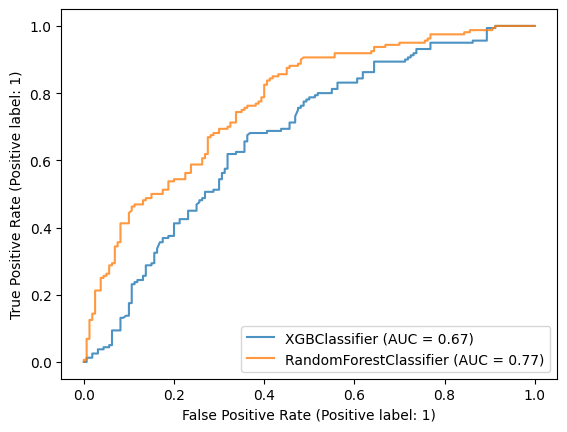

XGBoost results:
[15:52:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.559375
 F1 score: 0.36771300448430494
 Test AUC: 0.5593750000000001
[0.559375, 0.36771300448430494, 0.5593750000000001]
Random forest results:
Accuracy: 0.596875
 F1 score: 0.7020785219399538
 Test AUC: 0.596875
[0.596875, 0.7020785219399538, 0.596875]


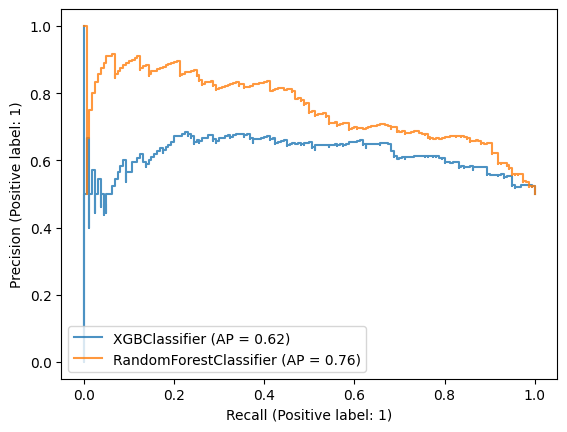

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.559375  0.367713        0.559375
Random forest  0.596875  0.702079        0.596875


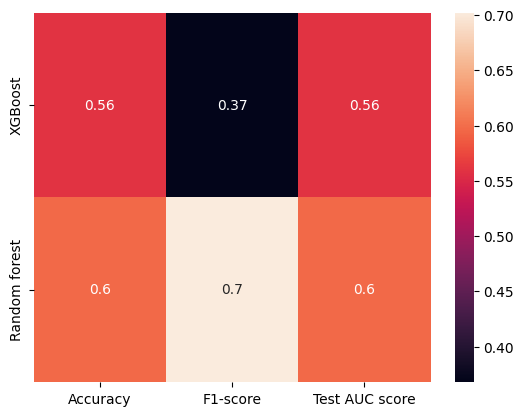

In [14]:
#CSN-SIGNOR
#ROC
X_train_CSN, X_test_SIGNOR, y_train_CSN, y_test_SIGNOR = prepare_data(drop_train=only_CSN, drop_test=only_SIGNOR)
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_CSN_SIGNOR, params_xgb_CSN_SIGNOR = teach_print_test_all(X_train_CSN, X_test_SIGNOR, 
                                                                                       y_train_CSN, y_test_SIGNOR, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_CSN_SIGNOR, params_rfc_CSN_SIGNOR = teach_print_test_all(X_train_CSN, X_test_SIGNOR, 
                                                                                      y_train_CSN, y_test_SIGNOR, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_CSN_SIGNOR, display_rfc_CSN_SIGNOR])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_CSN_SIGNOR, params_xgb_CSN_SIGNOR = teach_print_test_all(X_train_CSN, X_test_SIGNOR, 
                                                                                      y_train_CSN, y_test_SIGNOR, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_CSN_SIGNOR, params_rfc_CSN_SIGNOR = teach_print_test_all(X_train_CSN, X_test_SIGNOR, 
                                                                                      y_train_CSN, y_test_SIGNOR, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_CSN_SIGNOR, display_rfc_CSN_SIGNOR])
plt.show()
#heatmap
params_df_CSN_SIGNOR = params_heatmap(params_xgb=params_xgb_CSN_SIGNOR, params_rfc=params_rfc_CSN_SIGNOR)

XGBoost results:
[15:52:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.5875
 F1 score: 0.3592233009708738
 Test AUC: 0.5874999999999999
[0.5875, 0.3592233009708738, 0.5874999999999999]
Random forest results:
Accuracy: 0.509375
 F1 score: 0.03680981595092024
 Test AUC: 0.509375
[0.509375, 0.03680981595092024, 0.509375]


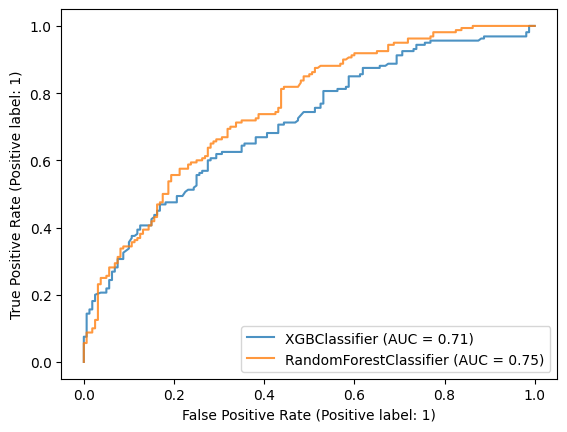

XGBoost results:
[15:52:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.5875
 F1 score: 0.3592233009708738
 Test AUC: 0.5874999999999999
[0.5875, 0.3592233009708738, 0.5874999999999999]
Random forest results:
Accuracy: 0.509375
 F1 score: 0.03680981595092024
 Test AUC: 0.509375
[0.509375, 0.03680981595092024, 0.509375]


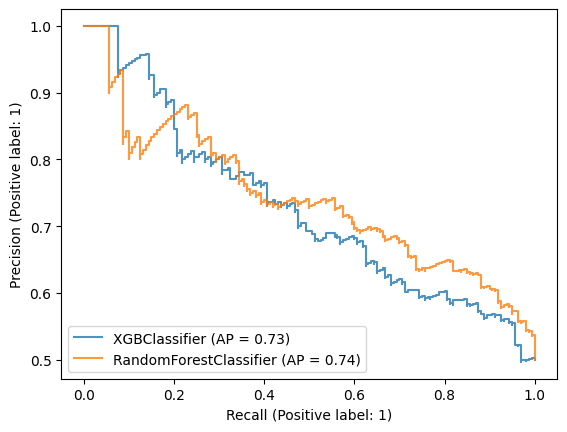

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.587500  0.359223        0.587500
Random forest  0.509375  0.036810        0.509375


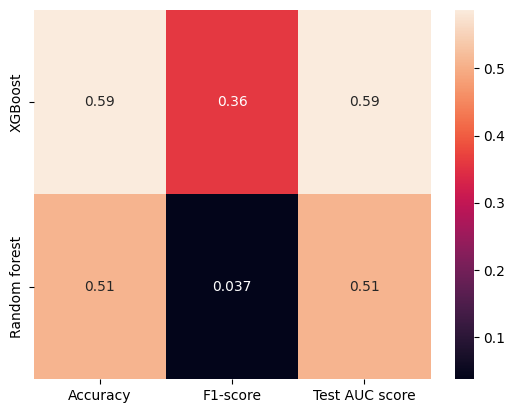

In [15]:
#SIGNOR_CSN
#ROC
X_train_SIGNOR, X_test_CSN, y_train_SIGNOR, y_test_CSN = prepare_data(drop_train=only_SIGNOR, drop_test=only_CSN)
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_SIGNOR_CSN, params_xgb_SIGNOR_CSN = teach_print_test_all(X_train_SIGNOR, X_test_CSN, 
                                                                                       y_train_SIGNOR, y_test_CSN, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_SIGNOR_CSN, params_rfc_SIGNOR_CSN = teach_print_test_all(X_train_SIGNOR, X_test_CSN, 
                                                                                      y_train_SIGNOR, y_test_CSN, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_SIGNOR_CSN, display_rfc_SIGNOR_CSN])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_SIGNOR_CSN, params_xgb_SIGNOR_CSN = teach_print_test_all(X_train_SIGNOR, X_test_CSN, 
                                                                                      y_train_SIGNOR, y_test_CSN, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_SIGNOR_CSN, params_rfc_SIGNOR_CSN = teach_print_test_all(X_train_SIGNOR, X_test_CSN, 
                                                                                      y_train_SIGNOR, y_test_CSN, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_SIGNOR_CSN, display_rfc_SIGNOR_CSN])
plt.show()
#heatmap
params_df_SIGNOR_CSN = params_heatmap(params_xgb=params_xgb_SIGNOR_CSN, params_rfc=params_rfc_SIGNOR_CSN)

XGBoost results:
[15:52:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.69375
 F1 score: 0.69375
 Test AUC: 0.69375
[0.69375, 0.69375, 0.69375]
Random forest results:
Accuracy: 0.665625
 F1 score: 0.7115902964959568
 Test AUC: 0.6656249999999999
[0.665625, 0.7115902964959568, 0.6656249999999999]


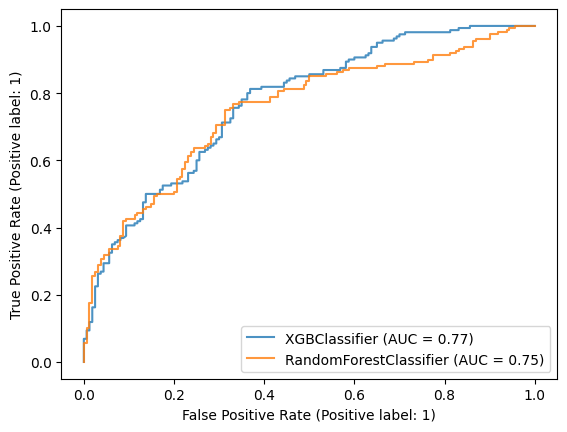

XGBoost results:
[15:52:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.69375
 F1 score: 0.69375
 Test AUC: 0.69375
[0.69375, 0.69375, 0.69375]
Random forest results:
Accuracy: 0.665625
 F1 score: 0.7115902964959568
 Test AUC: 0.6656249999999999
[0.665625, 0.7115902964959568, 0.6656249999999999]


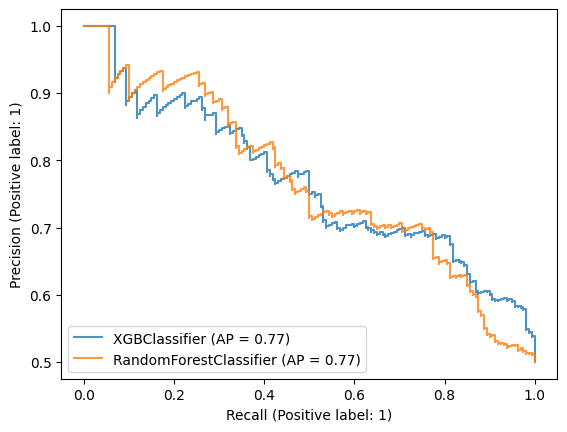

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.693750   0.69375        0.693750
Random forest  0.665625   0.71159        0.665625


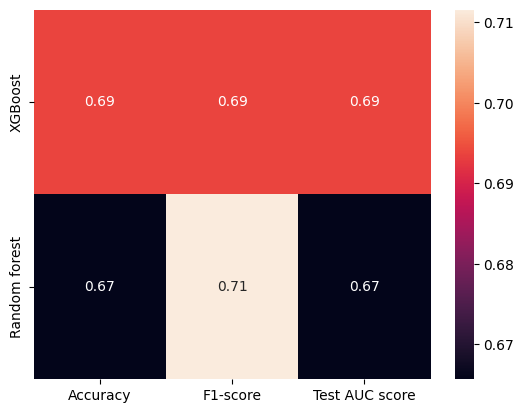

In [16]:
#SIGNOR_ReactomeFI
#ROC
X_train_SIGNOR, X_test_ReactomeFI, y_train_SIGNOR, y_test_ReactomeFI = prepare_data(drop_train=only_SIGNOR, drop_test=only_ReactomeFI)
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_SIGNOR_ReactomeFI, params_xgb_SIGNOR_ReactomeFI = teach_print_test_all(X_train_SIGNOR, X_test_ReactomeFI, 
                                                                                       y_train_SIGNOR, y_test_ReactomeFI, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_SIGNOR_ReactomeFI, params_rfc_SIGNOR_ReactomeFI = teach_print_test_all(X_train_SIGNOR, X_test_ReactomeFI, 
                                                                                      y_train_SIGNOR, y_test_ReactomeFI, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_SIGNOR_ReactomeFI, display_rfc_SIGNOR_ReactomeFI])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_SIGNOR_ReactomeFI, params_xgb_SIGNOR_ReactomeFI = teach_print_test_all(X_train_SIGNOR, X_test_ReactomeFI, 
                                                                                      y_train_SIGNOR, y_test_ReactomeFI, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_SIGNOR_ReactomeFI, params_rfc_SIGNOR_ReactomeFI = teach_print_test_all(X_train_SIGNOR, X_test_ReactomeFI, 
                                                                                      y_train_SIGNOR, y_test_ReactomeFI, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_SIGNOR_ReactomeFI, display_rfc_SIGNOR_ReactomeFI])
plt.show()
#heatmap
params_df_SIGNOR_ReactomeFI = params_heatmap(params_xgb=params_xgb_SIGNOR_ReactomeFI, params_rfc=params_rfc_SIGNOR_ReactomeFI)

XGBoost results:
[15:52:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.628125
 F1 score: 0.5824561403508772
 Test AUC: 0.628125
[0.628125, 0.5824561403508772, 0.628125]
Random forest results:
Accuracy: 0.7
 F1 score: 0.6129032258064516
 Test AUC: 0.7000000000000001
[0.7, 0.6129032258064516, 0.7000000000000001]


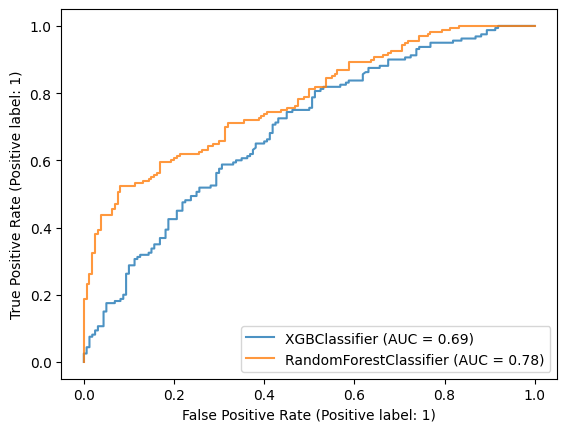

XGBoost results:
[15:52:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.628125
 F1 score: 0.5824561403508772
 Test AUC: 0.628125
[0.628125, 0.5824561403508772, 0.628125]
Random forest results:
Accuracy: 0.7
 F1 score: 0.6129032258064516
 Test AUC: 0.7000000000000001
[0.7, 0.6129032258064516, 0.7000000000000001]


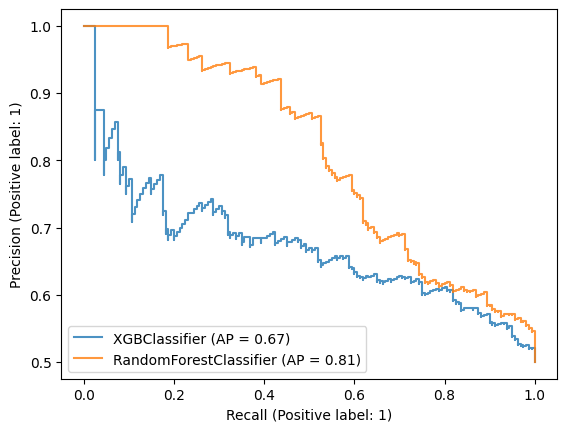

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.628125  0.582456        0.628125
Random forest  0.700000  0.612903        0.700000


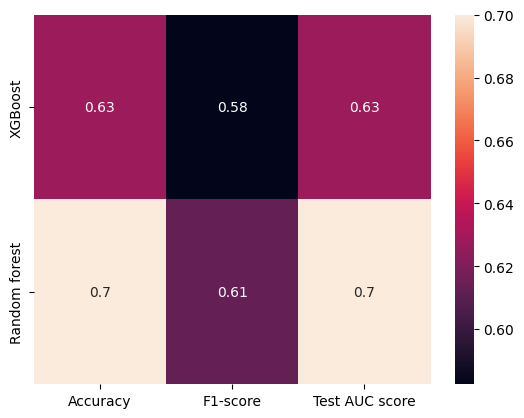

In [17]:
#ReactomeFI-SIGNOR
#ROC
X_train_ReactomeFI, X_test_SIGNOR, y_train_ReactomeFI, y_test_SIGNOR = prepare_data(drop_train=only_ReactomeFI, drop_test=only_SIGNOR)
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_ReactomeFI_SIGNOR, params_xgb_ReactomeFI_SIGNOR = teach_print_test_all(X_train_ReactomeFI, X_test_SIGNOR, 
                                                                                       y_train_ReactomeFI, y_test_SIGNOR, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_ReactomeFI_SIGNOR, params_rfc_ReactomeFI_SIGNOR = teach_print_test_all(X_train_ReactomeFI, X_test_SIGNOR, 
                                                                                      y_train_ReactomeFI, y_test_SIGNOR, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_ReactomeFI_SIGNOR, display_rfc_ReactomeFI_SIGNOR])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_ReactomeFI_SIGNOR, params_xgb_ReactomeFI_SIGNOR = teach_print_test_all(X_train_ReactomeFI, X_test_SIGNOR, 
                                                                                      y_train_ReactomeFI, y_test_SIGNOR, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_ReactomeFI_SIGNOR, params_rfc_ReactomeFI_SIGNOR = teach_print_test_all(X_train_ReactomeFI, X_test_SIGNOR, 
                                                                                      y_train_ReactomeFI, y_test_SIGNOR, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_ReactomeFI_SIGNOR, display_rfc_ReactomeFI_SIGNOR])
plt.show()
#heatmap
params_df_ReactomeFI_SIGNOR = params_heatmap(params_xgb=params_xgb_ReactomeFI_SIGNOR, params_rfc=params_rfc_ReactomeFI_SIGNOR)

XGBoost results:
[15:52:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.571875
 F1 score: 0.6204986149584488
 Test AUC: 0.5718749999999999
[0.571875, 0.6204986149584488, 0.5718749999999999]
Random forest results:
Accuracy: 0.53125
 F1 score: 0.6781115879828327
 Test AUC: 0.53125
[0.53125, 0.6781115879828327, 0.53125]


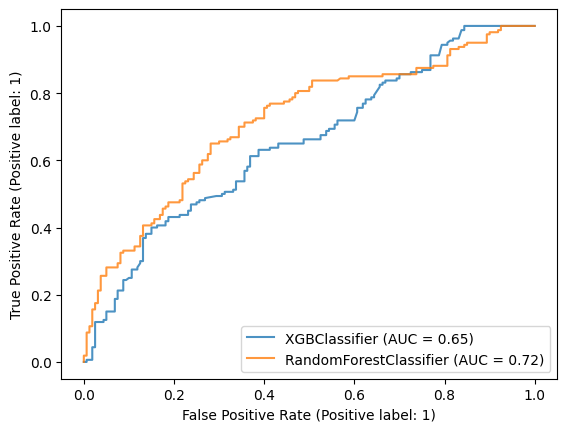

XGBoost results:
[15:52:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.571875
 F1 score: 0.6204986149584488
 Test AUC: 0.5718749999999999
[0.571875, 0.6204986149584488, 0.5718749999999999]
Random forest results:
Accuracy: 0.53125
 F1 score: 0.6781115879828327
 Test AUC: 0.53125
[0.53125, 0.6781115879828327, 0.53125]


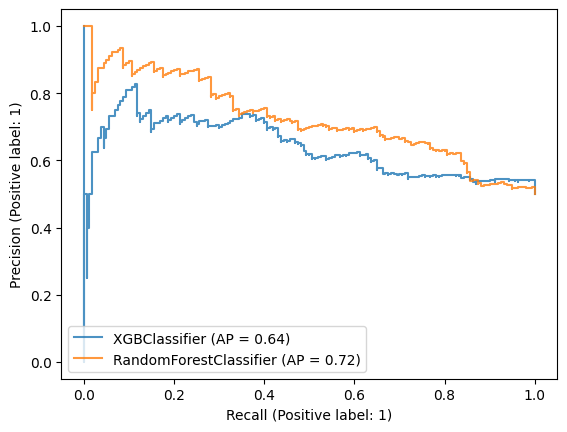

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.571875  0.620499        0.571875
Random forest  0.531250  0.678112        0.531250


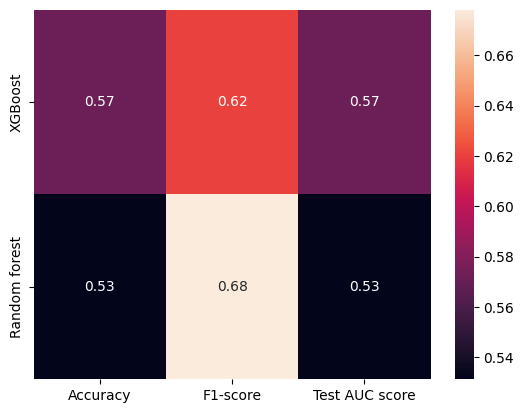

In [18]:
#CSN-ReactomeFI
#ROC
X_train_CSN, X_test_ReactomeFI, y_train_CSN, y_test_ReactomeFI = prepare_data(drop_train=only_CSN, drop_test=only_ReactomeFI)
print("XGBoost results:")
xgb_pred_train_, xgb_pred_test, display_xgb_CSN_ReactomeFI, params_xgb_CSN_ReactomeFI = teach_print_test_all(X_train_CSN, X_test_ReactomeFI, 
                                                                                       y_train_CSN, y_test_ReactomeFI, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_CSN_ReactomeFI, params_rfc_CSN_ReactomeFI = teach_print_test_all(X_train_CSN, X_test_ReactomeFI, 
                                                                                      y_train_CSN, y_test_ReactomeFI, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_CSN_ReactomeFI, display_rfc_CSN_ReactomeFI])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_CSN_ReactomeFI, params_xgb_CSN_ReactomeFI = teach_print_test_all(X_train_CSN, X_test_ReactomeFI, 
                                                                                      y_train_CSN, y_test_ReactomeFI, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_CSN_ReactomeFI, params_rfc_CSN_ReactomeFI = teach_print_test_all(X_train_CSN, X_test_ReactomeFI, 
                                                                                      y_train_CSN, y_test_ReactomeFI, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_CSN_ReactomeFI, display_rfc_CSN_ReactomeFI])
plt.show()
#heatmap
params_df_CSN_ReactomeFI = params_heatmap(params_xgb=params_xgb_CSN_ReactomeFI, params_rfc=params_rfc_CSN_ReactomeFI)

XGBoost results:
[15:52:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.509375
 F1 score: 0.04848484848484849
 Test AUC: 0.509375
[0.509375, 0.04848484848484849, 0.509375]
Random forest results:
Accuracy: 0.5
 F1 score: 0.0
 Test AUC: 0.5
[0.5, 0.0, 0.5]


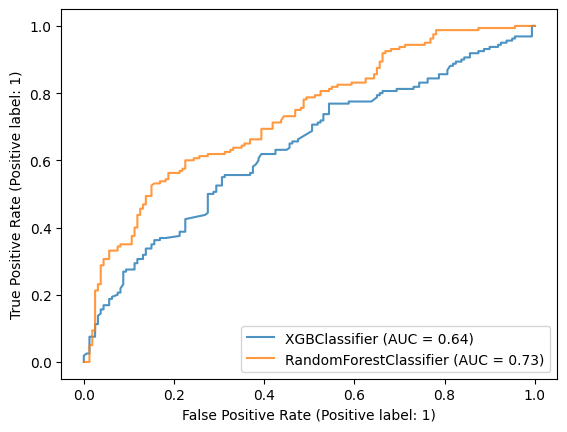

XGBoost results:
[15:52:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.509375
 F1 score: 0.04848484848484849
 Test AUC: 0.509375
[0.509375, 0.04848484848484849, 0.509375]
Random forest results:
Accuracy: 0.5
 F1 score: 0.0
 Test AUC: 0.5
[0.5, 0.0, 0.5]


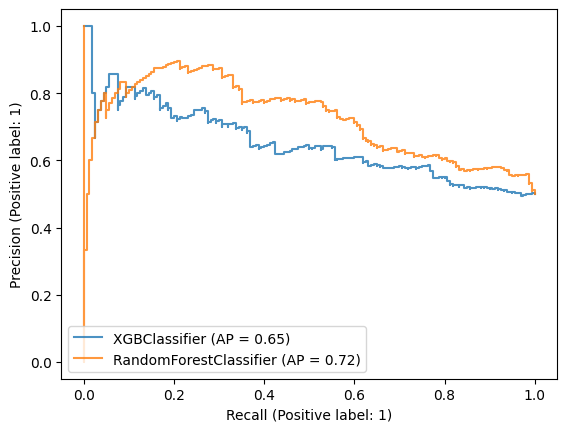

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.509375  0.048485        0.509375
Random forest  0.500000  0.000000        0.500000


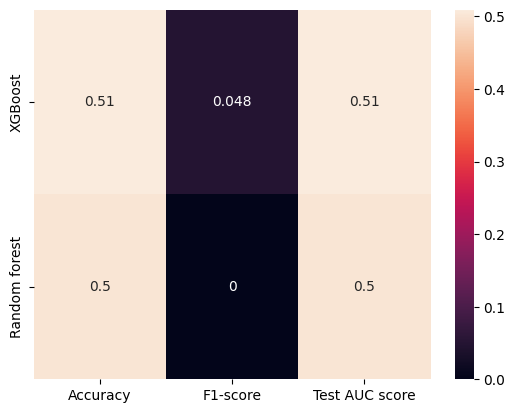

In [19]:
#ReactomeFI_CSN
#ROC
X_train_ReactomeFI, X_test_CSN, y_train_ReactomeFI, y_test_CSN = prepare_data(drop_train=only_ReactomeFI, drop_test=only_CSN)
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_ReactomeFI_CSN, params_xgb_ReactomeFI_CSN = teach_print_test_all(X_train_ReactomeFI, X_test_CSN, 
                                                                                       y_train_ReactomeFI, y_test_CSN, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_ReactomeFI_CSN, params_rfc_ReactomeFI_CSN = teach_print_test_all(X_train_ReactomeFI, X_test_CSN, 
                                                                                      y_train_ReactomeFI, y_test_CSN, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_ReactomeFI_CSN, display_rfc_ReactomeFI_CSN])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_ReactomeFI_CSN, params_xgb_ReactomeFI_CSN = teach_print_test_all(X_train_ReactomeFI, X_test_CSN, 
                                                                                      y_train_ReactomeFI, y_test_CSN, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_ReactomeFI_CSN, params_rfc_ReactomeFI_CSN = teach_print_test_all(X_train_ReactomeFI, X_test_CSN, 
                                                                                      y_train_ReactomeFI, y_test_CSN, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_ReactomeFI_CSN, display_rfc_ReactomeFI_CSN])
plt.show()
#heatmap
params_df_ReactomeFI_CSN = params_heatmap(params_xgb=params_xgb_ReactomeFI_CSN, params_rfc=params_rfc_ReactomeFI_CSN)

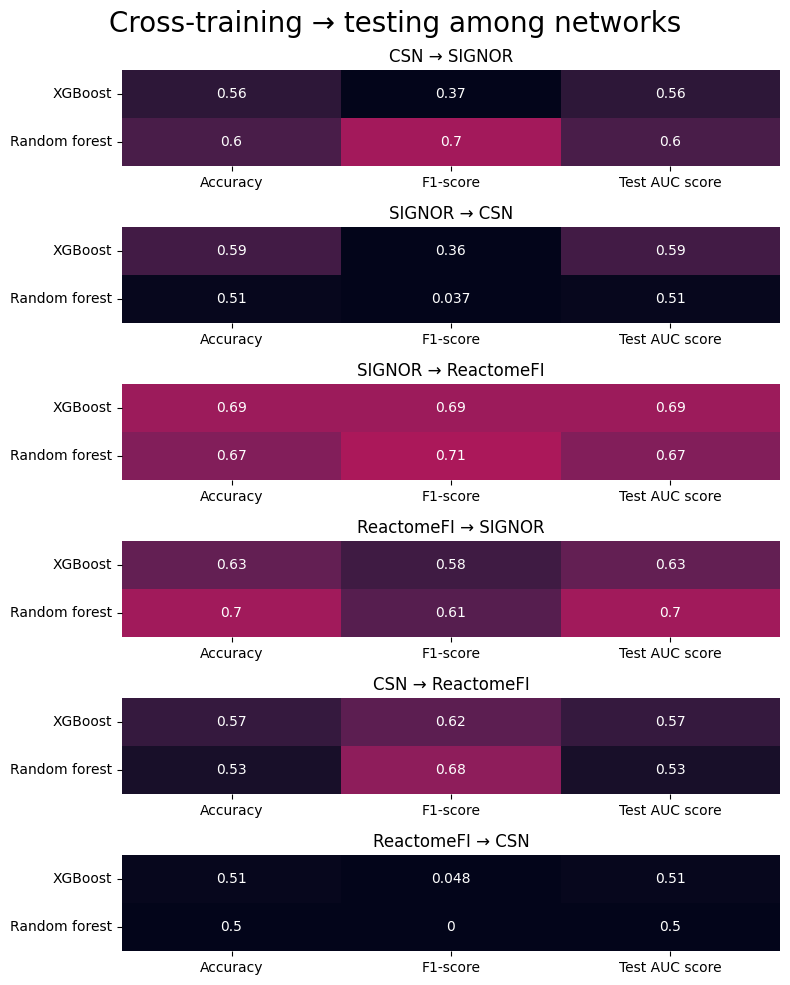

In [20]:
plt.rcParams["figure.figsize"] = [8, 10]
plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, sharey=False)
fig.subplots_adjust(wspace=0.02)

vmin = 0.50
vmax = 1

plt.suptitle("Cross-training → testing among networks", fontsize=20)

sns.heatmap(params_df_CSN_SIGNOR, annot=True, ax=ax1, cbar=False, vmin=vmin, vmax=vmax)
ax1.set_title('CSN → SIGNOR')
sns.heatmap(params_df_SIGNOR_CSN, annot=True, ax=ax2, cbar=False, vmin=vmin, vmax=vmax)
ax2.set_title('SIGNOR → CSN')
sns.heatmap(params_df_SIGNOR_ReactomeFI, annot=True, ax=ax3, cbar=False, vmin=vmin, vmax=vmax)
ax3.set_title('SIGNOR → ReactomeFI')
sns.heatmap(params_df_ReactomeFI_SIGNOR, annot=True, ax=ax4, cbar=False, vmin=vmin, vmax=vmax)
ax4.set_title('ReactomeFI → SIGNOR')
sns.heatmap(params_df_CSN_ReactomeFI, annot=True, ax=ax5, cbar=False, vmin=vmin, vmax=vmax)
ax5.set_title('CSN → ReactomeFI')
sns.heatmap(params_df_ReactomeFI_CSN, annot=True, ax=ax6, cbar=False, vmin=vmin, vmax=vmax)
ax6.set_title('ReactomeFI → CSN')

plt.show()